In [ ]:
# !unzip d2d-data.zip

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import special as sp
from scipy.stats import gaussian_kde
from scipy.io import loadmat
from sklearn.neighbors import KernelDensity
from scipy import special as sp
import warnings
warnings.filterwarnings('ignore')
import pdb

# Data Load

## D2D data

In [ ]:
def D2D_data_linear():   
  """
  Data normalised with respect to their global means
  """
  UE1head_UE2head_LOS_indoor = pd.read_csv('/content/Datasets/D2D_UE1head_UE2head_LOS_Indoor_1khz_mv.txt', delimiter = "\t", header=None)
  UE1head_UE2head_NLOS_indoor = pd.read_csv('/content/Datasets/D2D_UE1head_UE2head_NLOS_indoor_1khz_mv.txt', delimiter = "\t", header=None)
  UE1head_UE2head_NLOS_outdoor = pd.read_csv('/content/Datasets/D2D_UE1head_UE2head_NLOS_outdoor_1khz_mv.txt', delimiter = "\t", header=None)
    
  return UE1head_UE2head_LOS_indoor.T[500:10000].reset_index(drop=True), UE1head_UE2head_NLOS_indoor.T[500:10000].reset_index(drop=True), UE1head_UE2head_NLOS_outdoor.T[500:10000].reset_index(drop=True)

def D2D_SSF_data_linear():   
  """
  Data normalised with respect to their local means (ssf)
  """
  UE1head_UE2pocket_LOS = pd.read_csv('/content/Datasets/d2d_ssf_UE1head_UE2pocket_LOS_mv.txt', delimiter = "\t", header=None, )
  UE1head_UE2pocket_NLOS = pd.read_csv('/content/Datasets/d2d_ssf_UE1head_UE2pocket_NLOS_mv.txt', delimiter = "\t", header=None)
  UE1text_UE2head_LOS = pd.read_csv('/content/Datasets/d2d_ssf_UE1texting_UE2head_LOS_mv.txt', delimiter = "\t", header=None)

  return UE1head_UE2pocket_LOS.T, UE1head_UE2pocket_NLOS.T, UE1text_UE2head_LOS.T


##########################
#### LOAD GLOBAL MEAN ####
##########################
# SSF_pathAB_dB = pd.DataFrame()
UE1head_UE2head_LOS_indoor, \
UE1head_UE2head_NLOS_indoor, \
UE1head_UE2head_NLOS_outdoor = D2D_data_linear()

##########################
####  LOAD LOCAL MEAN ####
##########################
# SSF_pathAB_linear = pd.DataFrame()
UE1head_UE2pocket_LOS, \
UE1head_UE2pocket_NLOS, \
UE1text_UE2head_LOS = D2D_SSF_data_linear()


##########################
#### PRINT STATISTICS ####
##########################
print('Normalised wrt Global Mean')
print('UE1: Head | UE2: Head (LOS - Indoor) Statistics:')
display(UE1head_UE2head_LOS_indoor.describe())
print('UE1: Head | UE2: Head (NLOS - Indoor) Statistics:')
display(UE1head_UE2head_NLOS_indoor.describe())
print('UE1: Head | UE2: Head (NLOS - Outdoor) Statistics:')
display(UE1head_UE2head_NLOS_outdoor.describe())

print('Normalised wrt Local Mean')
print('UE1: Head | UE2: Pocket (LOS) Statistics:')
display(UE1head_UE2pocket_LOS.describe())
print('UE1: Head | UE2: Pocket (NLOS) Statistics:')
display(UE1head_UE2pocket_NLOS.describe())
print('UE1: Texting | UE2: Head (LOS) Statistics:')
display(UE1text_UE2head_LOS.describe())


Normalised wrt Global Mean
UE1: Head | UE2: Head (LOS - Indoor) Statistics:


,0
count,9500.000000
mean,0.921931
std,0.601470
min,0.017674
25%,0.508960
50%,0.773810
75%,1.185725
max,4.710200


UE1: Head | UE2: Head (NLOS - Indoor) Statistics:


,0
count,9500.000000
mean,0.995891
std,0.648062
min,0.012973
25%,0.498070
50%,0.875770
75%,1.381550
max,4.511200


UE1: Head | UE2: Head (NLOS - Outdoor) Statistics:


,0
count,9500.000000
mean,1.063997
std,0.682374
min,0.086185
25%,0.612620
50%,0.915005
75%,1.352000
max,4.497600


Normalised wrt Local Mean
UE1: Head | UE2: Pocket (LOS) Statistics:


,0
count,352.000000
mean,0.984655
std,0.325573
min,0.179790
25%,0.753408
50%,0.987740
75%,1.197825
max,2.244300


UE1: Head | UE2: Pocket (NLOS) Statistics:


,0
count,359.000000
mean,0.963644
std,0.263986
min,0.166430
25%,0.789900
50%,0.954080
75%,1.145800
max,1.933800


UE1: Texting | UE2: Head (LOS) Statistics:


,0
count,329.000000
mean,0.989625
std,0.269059
min,0.182660
25%,0.825610
50%,0.981770
75%,1.162800
max,1.812700


# Auxiliary Methods

In [ ]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set") 

def shadowedKappaMuPDF(r, kappa, mu, omega, md):
  '''
  shadowed kappa-mu pdf (type 1).
  '''
  A = 2 * r**((2*mu) -1) / omega**(mu)
  B = (mu**mu * md**md * (1+kappa)**mu) / (sp.gamma(mu) * ((mu*kappa)+md)**md)
  C = np.exp((- mu * (1+kappa) * r**2) / omega)
  D = (mu**2) * kappa * (1+kappa) * (r**2)
  E = ((mu*kappa)+md) * omega
  F = sp.hyp1f1(md, mu, D / E)

  pdf = A * B * C * F
  return pdf

def KappaMuPDF(r, kappa, mu, omega):
  '''
  kappa-mu pdf.
  '''
  A = (2*mu * ((1 + kappa)**((mu+1)/2))) \
          /(np.sqrt(omega) * (kappa**((mu-1)/2)) * np.exp(mu * kappa))
  B = (r / np.sqrt(omega))**(mu)
  C = np.exp(-mu*(1+kappa) * (r/np.sqrt(omega))**2)
  D = sp.iv(mu-1, 2*mu * np.sqrt(kappa * (1+kappa)) * (r/np.sqrt(omega)))

  pdf = A * B * C * D
  return pdf

def EtaMuPDF(r, eta, mu, omega):
  '''
  eta-mu pdf.
  '''
  if eta == 0:
    eta = 0.0009
  h = 0.25 * (2 + eta + 1/eta)
  H = 0.25 * (1/eta - eta)
  if H == 0:
    H = 10e-5

  A = (4 * math.sqrt(math.pi) * (mu**(mu + 0.5)) * (h**mu)) / (sp.gamma(mu) * (H**(mu - 0.5)) * math.sqrt(omega)) 
  B = (r / math.sqrt( omega ) ) **(2 * mu)
  C = np.exp( -2 * mu * h * ( ( r / math.sqrt( omega ) ) ** 2 ) )
  D = sp.iv( mu-0.5, 2 * mu * H * (( r / math.sqrt( omega ) )**2) )
  pdf = A * B * C * D
  return pdf

def AlphaMuPDF(r, alpha, mu, r_hat):
  '''
  alpha-mu pdf.
  '''
  A = (alpha * (mu**mu) * (r**((alpha * mu)-1))) / (sp.gamma(mu) * (r_hat**(alpha * mu)))
  B = np.exp( - mu * ((r**alpha) / (r_hat**alpha)))

  pdf = A * B 
  return pdf

def kldiv(pVec1, pVec2):
  '''
  Kullback-Leibler divergence.
  '''
  KL = np.sum(pVec1*(np.log2(pVec1)-np.log2(pVec2)))
  return KL

def RAD(kldiv1, kldiv2):
  '''
  Resistor-Average Distance.
  '''
  RAD = 1/(1/kldiv1+1/kldiv2)
  return RAD

def getDensityEstimationSamples(linear_data, nExtractedSamples, case):
  '''
  Extracted KDE uniformly spaced samples from the data.
  '''
  Xdata = np.linspace(linear_data.min(), linear_data.max(), nExtractedSamples).reshape(-1, 1)
  kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(linear_data.values.reshape(-1, 1))
  
  logkde = kde.score_samples(Xdata)
  Ydata = np.exp(logkde).reshape(-1,1)
  plt.figure(figsize=(10,7))
  plt.scatter(20*np.log10(Xdata), Ydata, c='magenta')
  plt.title(f'{case}')
  plt.ylabel('Density')
  plt.xlabel('Small Scale Fading (dB)')
  plt.grid()
  plt.show()
  return Xdata, Ydata

def printSummary(case, fitnessType):
  print('='*30+'\n'+'Genetic Algorithm Fitting\nFitness Type: {}\nCase: {}\n'.format(fitnessType, case))

def computeAIC(data, n, K, nls_ku, ga_ku_mse, ga_ku_rad, ga_eu_mse, ga_eu_rad):#, ga_sku_mse, ga_sku_rad):
  # AIC NLS - KAPPA MU
  sum = np.sum(np.log(KappaMuPDF(data, nls_ku[0], nls_ku[1], nls_ku[2]).astype(float)))
  AIC_nls_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)
  
  # # AIC NLS - ALPHA MU
  # sum = np.sum(np.log(AlphaMuPDF(data, nls_eu[0], nls_eu[1], nls_eu[2]).astype(float)))
  # AIC_nls_eta_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

  # AIC GENETIC ALGORITHM KAPPA MU - FITNESS: MSE
  sum = np.sum(np.log(KappaMuPDF(data, ga_ku_mse[0], ga_ku_mse[1], ga_ku_mse[2])))
  AIC_ga_kappa_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)
  
  # AIC GENETIC ALGORITHM KAPPA MU - FITNESS: RAD
  sum = np.sum(np.log(KappaMuPDF(data, ga_ku_rad[0], ga_ku_rad[1], ga_ku_rad[2])))
  AIC_ga_kappa_mu_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

  # AIC GENETIC ALGORITHM ALPHA MU - FITNESS: MSE
  sum = np.sum(np.log(EtaMuPDF(data, ga_eu_mse[0], ga_eu_mse[1], ga_eu_mse[2])))
  AIC_ga_eta_mu = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

  # AIC GENETIC ALGORITHM ALPHA MU - FITNESS: RAD
  sum = np.sum(np.log(EtaMuPDF(data, ga_eu_rad[0], ga_eu_rad[1], ga_eu_rad[2])))
  AIC_ga_eta_mu_rad = -2*sum + 2*K + (2*K*(K+1))/(n-K-1)

  K = K+1

  rads = {'Methods':['NLS - KappaMu', \
                      'GA - KappaMu (Fitness = MSE)', 'GA - KappaMu (Fitness = RAD)',\
                      'GA - EtaMu (Fitness = MSE)', 'GA - EtaMu (Fitness = RAD)'],\
                    #  'NLS - Shad. KappaMu T1', 'GA - Shad. KappaMu T1 (Fitness = MSE)',\
                    #  'GA - Shad. KappaMu T1 (Fitness = RAD)'],
          
      'Akaike Information Criteria':[AIC_nls_kappa_mu[0], \
                                     AIC_ga_kappa_mu[0], AIC_ga_kappa_mu_rad[0],
                                     AIC_ga_eta_mu[0] , AIC_ga_eta_mu_rad[0]]}
                                    # AIC_nls_shadowed_kappa_mu[0], AIC_ga_shadowed_kappa_mu[0], AIC_ga_shadowed_kappa_mu_rad[0]]}

  df = pd.DataFrame(rads)
  display(df.sort_values(by='Akaike Information Criteria').reset_index(drop=True))
  return df

def plotResults(Xdata, Ydata, ku_pdf, ga_ku_mse, ga_ku_rad, ga_eu_mse, ga_eu_rad, case):#, sku_pdf, ga_sku_mse, ga_sku_rad, case):
    plt.figure(figsize=((10,7)))
    plt.scatter(20*np.log10(Xdata), Ydata, c='black')
    plt.plot(20*np.log10(Xdata), ku_pdf, label=r'$\kappa$-$\mu$ NLS')
    # plt.plot(20*np.log10(Xdata), au_pdf, label=r'$\eta$-$\mu$ NLS')
    plt.plot(20*np.log10(Xdata), KappaMuPDF(Xdata, ga_ku_mse[0], ga_ku_mse[1], ga_ku_mse[2]), label=r'GA: $\kappa$-$\mu$ (MSE)')
    plt.plot(20*np.log10(Xdata), KappaMuPDF(Xdata, ga_ku_rad[0], ga_ku_rad[1], ga_ku_rad[2]), label=r'GA: $\kappa$-$\mu$ (RAD)')
    plt.plot(20*np.log10(Xdata), EtaMuPDF(Xdata, ga_eu_mse[0], ga_eu_mse[1], ga_eu_mse[2]), label=r'GA: $\eta$-$\mu$ (MSE)')
    plt.plot(20*np.log10(Xdata), EtaMuPDF(Xdata, ga_eu_rad[0], ga_eu_rad[1], ga_eu_rad[2]), label=r'GA: $\eta$-$\mu$ (RAD)')
    # plt.plot(20*np.log10(Xdata), sku_pdf, label=r'Shad. $\kappa$-$\mu$ NLS')
    # plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF(Xdata, ga_sku_mse[0], ga_sku_mse[1], ga_sku_mse[2], ga_sku_mse[3]), label='Shad. $\kappa$-$\mu$ GA (MSE)')
    # plt.plot(20*np.log10(Xdata), shadowedKappaMuPDF(Xdata, ga_sku_rad[0], ga_sku_rad[1], ga_sku_rad[2], ga_sku_rad[3]), label='Shad. $\kappa$-$\mu$ GA (RAD)')
    
    plt.title(f'{case}')
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'Small Scale Fading (dB)')
    plt.ylabel('Density')
    plt.savefig('(dB) ku-eu_case_{}.pdf'.format(case, dpi=150))
    plt.show()
    
    plt.figure(figsize=((10,7)))
    plt.scatter(Xdata, Ydata, c='black')
    plt.plot(Xdata, ku_pdf, label=r'$\kappa$-$\mu$ NLS')
    # plt.plot(Xdata, eu_pdf, label=r'$\eta$-$\mu$ NLS')
    plt.plot(Xdata, KappaMuPDF(Xdata, ga_ku_mse[0], ga_ku_mse[1], ga_ku_mse[2]), label=r'GA: $\kappa$-$\mu$ (MSE)')
    plt.plot(Xdata, KappaMuPDF(Xdata, ga_ku_rad[0], ga_ku_rad[1], ga_ku_rad[2]), label=r'GA: $\kappa$-$\mu$ (RAD)')
    plt.plot(Xdata, EtaMuPDF(Xdata, ga_eu_mse[0], ga_eu_mse[1], ga_eu_mse[2]), label=r'GA: $\eta$-$\mu$ (MSE)')
    plt.plot(Xdata, EtaMuPDF(Xdata, ga_eu_rad[0], ga_eu_rad[1], ga_eu_rad[2]), label=r'GA: $\eta$-$\mu$ (RAD)')
    # plt.plot(Xdata, sku_pdf, label=r'Shad. $\kappa$-$\mu$ NLS')
    # plt.plot(Xdata, shadowedKappaMuPDF(Xdata, ga_sku_mse[0], ga_sku_mse[1], ga_sku_mse[2], ga_sku_mse[3]), label='Shad. $\kappa$-$\mu$ GA (MSE)')
    # plt.plot(Xdata, shadowedKappaMuPDF(Xdata, ga_sku_rad[0], ga_sku_rad[1], ga_sku_rad[2], ga_sku_rad[3]), label='Shad. $\kappa$-$\mu$ GA (RAD)')
    plt.title(f'{case}')
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'Small Scale Fading (linear)')
    plt.ylabel('Density')
    plt.savefig('(linear) ku-eu_case_{}.pdf'.format(case, dpi=150))
    plt.show()

# $\eta-\mu$: GA fitting

In [ ]:
def fitness_eu(X, Y, fitnessType, eta, mu, omega):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  (Eta-Mu)
  '''
  if fitnessType == 'MSE':
    y_pred = EtaMuPDF(X, eta, mu, omega)
    n = len(Y)
    cost = 1/n * np.sum(val**2 for val in (Y-y_pred))
    # pdb.set_trace()
    if np.isnan(cost):
      return 0
    else:
      return 1/cost

  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = EtaMuPDF(X, eta, mu, omega)/np.sum(EtaMuPDF(X, eta, mu, omega))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    if np.isnan(cost):
      return 0
    else:
      return 1/cost


def geneticAlgorithm_eu(X, Y, threshold, firstFlag=True, printPerGen=False):
  '''
  Genetic Algorithm incorporating Eta-Mu in the Fitness Function
  It fits eta, mu, r_hat
  '''
  if firstFlag:
    tic()
    printPerGen=printPerGen
  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.01, 50), # eta
                        random.uniform(0.01, 1.5), # mu
                        random.uniform(0.01, 2))) # omega

  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []
    for s in solutions:
      # if s[3] > 110: # Forcing Ms parameter to not get too high (avoiding overflow)
      #   s = list(s)
      #   s[3] = 105
      #   s = tuple(s)
      rankedSolutions.append( (fitness_eu(X, Y, fitnessType, s[0],s[1],s[2]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()
    
    if printPerGen:
      print(f'=== Generation: {i} === ')
      print(f'Fitness: {rankedSolutions[0][0]}')
      print('Best individual:')
      print(f'Eta: {rankedSolutions[0][1][0]}')
      print(f'Mu: {rankedSolutions[0][1][1]}')
      print(f'Omega: {rankedSolutions[0][1][2]}')

    # Keeping track the best params and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]
    
    # Check if it is good enough according to a satisfactory threshold:
    if bestCriteria > threshold:
      print('Satisfactory Threshold reached!')  
      toc()
      print('\nBest Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nOmega: {}'.format(bestParams[0],bestParams[1],bestParams[2]))
      return bestParams[0],bestParams[1],bestParams[2]

    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_eta = []
    elements_mu = []
    elements_omega = [] 

    for s in bestSolutions:
      elements_eta.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_omega.append(s[1][2])


    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_eta) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_omega) * random.uniform(0.975,1.025) # Mutation of 5%
      
      newGen.append((e1,e2,e3))

    solutions = newGen
    
    if i == nMaxGen-1:
      # print('Max number of generations reached! (Possible bad initialization)\nRestarting...\n')
      b0, b1, b2 = geneticAlgorithm_eu(X, Y, threshold, False, printPerGen)
    
      return b0, b1, b2

# $\kappa-\mu$: GA fitting

In [ ]:
def fitness_ku(X, Y, fitnessType, kappa, mu, omega):
  '''
  Fitness function (MSE/RAD) to determine how good a given solution is.
  (Kappa Mu)
  '''
  if fitnessType == 'MSE':
    y_pred = KappaMuPDF(X, kappa, mu, omega).astype(float)
    n = len(Y)
    sum = []
    for val in (Y-y_pred):
      sum.append(val**2)
    sum = np.sum(sum)
    cost = 1/n * sum
    return 1/cost
  elif fitnessType == 'RAD':
    pVec1 = Y/np.sum(Y)
    pVec2 = KappaMuPDF(X, kappa, mu, omega).astype(float)/np.sum(KappaMuPDF(X, kappa, mu, omega).astype(float))
    KLD_1 = kldiv(pVec1, pVec2)
    KLD_2 = kldiv(pVec2, pVec1)
    cost = RAD(KLD_1, KLD_2)
    return 1/cost


def geneticAlgorithm_ku(X, Y, threshold, firstFlag=True, printPerGen=False):
  '''
  Genetic Algorithm incorporating Kappa Mu in the Fitness Function
  It fits kappa, mu, omega
  '''
  if firstFlag:
    tic()
    printPerGen = printPerGen

  solutions = []
  bestParams = []
  bestCriteria = 0
  bestGen = 0


  # Generate solutions (chromossomes)
  for s in range(nPopulation):
    solutions.append((random.uniform(0.1, 70), # kappa
                        random.uniform(0.01, 1.5), # mu
                        random.uniform(0.01, 2)))  # omega = r_hat^2
              
  # Evolutionary Loop
  for i in range(nMaxGen):
    rankedSolutions = []	
    for s in solutions:
      # if s[0] > 90: # Forcing Ms parameter to not get too high (avoiding overflow)
      #   s = list(s)
      #   s[0] = 90
      #   s = tuple(s)
      rankedSolutions.append( (fitness_ku(X, Y, fitnessType, s[0],s[1],s[2]), s) )
    rankedSolutions.sort()
    rankedSolutions.reverse()
    
    if printPerGen:
      print(f'=== Generation: {i} === ')
      print(f'Fitness: {rankedSolutions[0][0]}')
      print('Best individual:')
      print(f'Kappa: {rankedSolutions[0][1][0]}')
      print(f'Mu: {rankedSolutions[0][1][1]}')
      print(f'Omega: {rankedSolutions[0][1][2]}\n')

    # Keeping track the best params and generation:
    if rankedSolutions[0][0] > bestCriteria:
      bestCriteria = rankedSolutions[0][0]
      bestGen = i
      bestParams = rankedSolutions[0][1]

    # Check if it is good enough according to a satisfactory threshold:
    if bestCriteria > threshold:
      print('Satisfactory Threshold reached!')  
      toc()
      print('\nBest Fitness: {}\nBest Gen: {}'.format(bestCriteria, bestGen))
      print('Kappa: {}\nMu: {}\nOmega: {}'.format(bestParams[0],bestParams[1],bestParams[2]))
      return bestParams[0],bestParams[1],bestParams[2]
    
    # Combine the best solutions and make a new solution of those combined solutions
    bestSolutions = rankedSolutions[:100]
    elements_kappa = []
    elements_mu = []
    elements_omega = [] 

    for s in bestSolutions:
      elements_kappa.append(s[1][0])
      elements_mu.append(s[1][1])
      elements_omega.append(s[1][2])


    newGen = []
    for _ in range(nPopulation):
      e1 = random.choice(elements_kappa) * random.uniform(0.975,1.025) # Mutation of 5%
      e2 = random.choice(elements_mu) * random.uniform(0.975,1.025) # Mutation of 5%
      e3 = random.choice(elements_omega) * random.uniform(0.975,1.025) # Mutation of 5%

      
      newGen.append((e1,e2,e3))

    solutions = newGen
    
    if i == nMaxGen-1:
      # print('Max number of generations reached! (Possible bad initialization)\nRestarting...\n')
      b0, b1, b2 = geneticAlgorithm_ku(X, Y, threshold, False, printPerGen)
    
      return b0, b1, b2

# Small Scale Fading Fitting (PARAMETERS)

In [ ]:
### PARAMETERS
nMaxGen = 20
nPopulation = 1000
nExtractedSamples = 81

## $\eta$-$\mu$ and $\kappa$-$\mu$



### D2D UE1 head - UE2 pocket LOS (indoor) [Case 1]

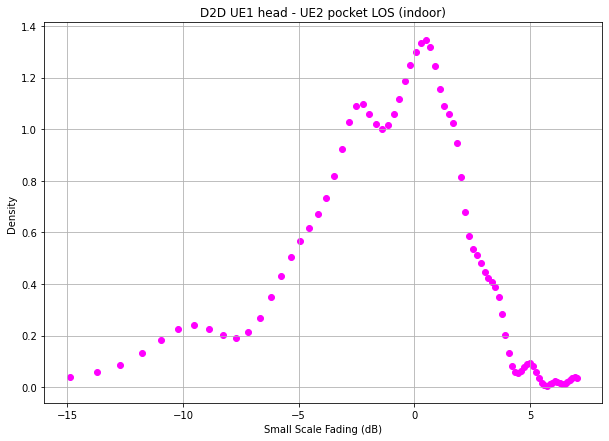

In [ ]:
case = 'D2D UE1 head - UE2 pocket LOS (indoor)'
estParameters_eu_ku_case1 = pd.DataFrame()
# estParameters_sku_case1 = pd.DataFrame()
Xdata, Ydata = getDensityEstimationSamples(UE1head_UE2pocket_LOS.dropna(), nExtractedSamples, case)

In [ ]:
print('='*30+' KAPPA-MU '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
ku_kappa_mse, ku_mu_mse, ku_omega_mse = geneticAlgorithm_ku(Xdata, Ydata, 234)

fitnessType = 'RAD'
printSummary(case, fitnessType)
ku_kappa_rad, ku_mu_rad, ku_omega_rad = geneticAlgorithm_ku(Xdata, Ydata, 77.7)

print('='*30+' ETA-MU '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
eu_eta_mse, eu_mu_mse, eu_omega_mse = geneticAlgorithm_eu(Xdata, Ydata, 162.3)

fitnessType = 'RAD'
printSummary(case, fitnessType)
eu_eta_rad, eu_mu_rad, eu_omega_rad = geneticAlgorithm_eu(Xdata, Ydata, 58.3)

============================== KAPPA-MU ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 head - UE2 pocket LOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 1.1661450862884521 seconds.

Best Fitness: 235.02413685095166
Best Gen: 4
Kappa: 38.16578054618963
Mu: 0.13857013821087316
Omega: 1.0499509808847343
Genetic Algorithm Fitting
Fitness Type: RAD
Case: D2D UE1 head - UE2 pocket LOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 30.761922121047974 seconds.

Best Fitness: 77.98544271347585
Best Gen: 4
Kappa: 4.281094868804863
Mu: 0.9068056821211983
Omega: 1.0585608120971515
============================== ETA-MU ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 head - UE2 pocket LOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 1.6004443168640137 seconds.

Best Fitness: [162.3304522]
Best Gen: 6
Kappa: 0.9708480892055831
Mu: 1.3211671969376197
Omega: 1.1090324744965665
Geneti

#### Estimated Parameters

In [ ]:
nls_ku_case1 = [70, 0.076636, 1.048] # KappaMu NLS
# nls_eu_case1 = [3.6888, 0.93352, 1.0856] # EtaMu NLS
# nls_sku_case1 = [9.6901, 0.51619, 1.0613, 20] # Shad. KappaMu T1 NLS

estParameters_eu_ku_case1['NLS - KappaMu'] = nls_ku_case1
# estParameters_eu_ku_case1['NLS - EtaMu'] = nls_eu_case1
estParameters_eu_ku_case1['GA: KappaMu - MSE'] = ku_kappa_mse, ku_mu_mse, ku_omega_mse
estParameters_eu_ku_case1['GA: KappaMu - RAD'] = ku_kappa_rad, ku_mu_rad, ku_omega_rad
estParameters_eu_ku_case1['GA: EtaMu - MSE'] = eu_eta_mse, eu_mu_mse, eu_omega_mse
estParameters_eu_ku_case1['GA: EtaMu - RAD'] = eu_eta_rad, eu_mu_rad, eu_omega_rad

index = pd.Index(['kappa/eta', 'mu', 'omega'])
estParameters_eu_ku_case1 = estParameters_eu_ku_case1.set_index(index)
display(estParameters_eu_ku_case1)


,NLS - KappaMu,GA: KappaMu - MSE,GA: KappaMu - RAD,GA: EtaMu - MSE,GA: EtaMu - RAD
kappa/eta,70.000000,38.165781,4.281095,0.970848,0.985220
mu,0.076636,0.138570,0.906806,1.321167,1.207819
omega,1.048000,1.049951,1.058561,1.109032,1.064350


#### Plots

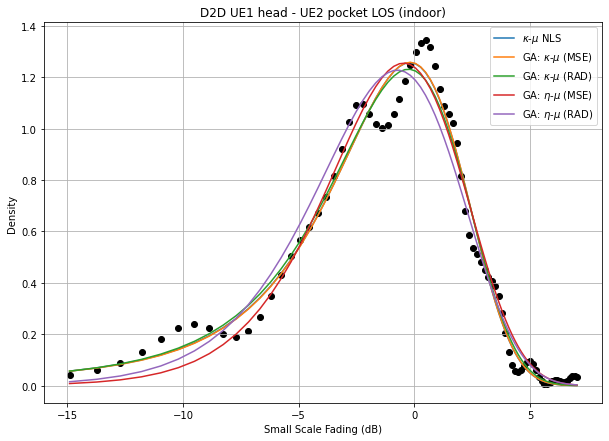

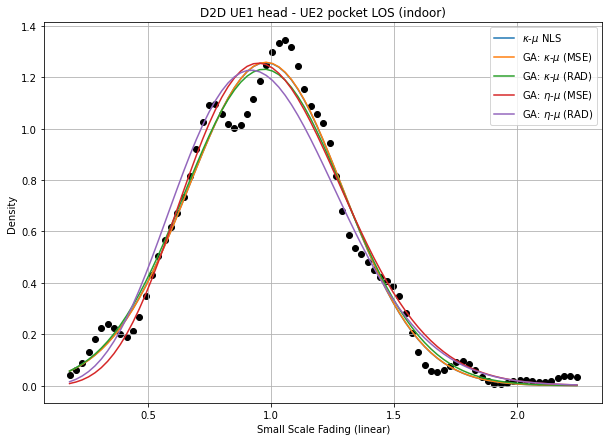

In [ ]:
ku_case1_pdf = KappaMuPDF(Xdata, nls_ku_case1[0], nls_ku_case1[1], nls_ku_case1[2]).astype(float)

plotResults(Xdata,\
     Ydata,\
     ku_case1_pdf,\
     estParameters_eu_ku_case1['GA: KappaMu - MSE'],\
     estParameters_eu_ku_case1['GA: KappaMu - RAD'],\
     estParameters_eu_ku_case1['GA: EtaMu - MSE'],\
     estParameters_eu_ku_case1['GA: EtaMu - RAD'],\
     case)

#### AIC Values

In [ ]:
## AIC Analysis
data = UE1head_UE2pocket_LOS.dropna()
n = len(data)
K = 3

print('Case: {}'.format(case))

AIC_case1 = computeAIC(data, n, K,\
                        nls_ku_case1,\
                        estParameters_eu_ku_case1['GA: KappaMu - MSE'],\
                        estParameters_eu_ku_case1['GA: KappaMu - RAD'],\
                        estParameters_eu_ku_case1['GA: EtaMu - MSE'],\
                        estParameters_eu_ku_case1['GA: EtaMu - RAD'],\
                        )

Case: D2D UE1 head - UE2 pocket LOS (indoor)


,Methods,Akaike Information Criteria
0,GA - EtaMu (Fitness = RAD),211.535185
1,GA - KappaMu (Fitness = RAD),212.174448
2,GA - EtaMu (Fitness = MSE),215.047071
3,GA - KappaMu (Fitness = MSE),216.408570
4,NLS - KappaMu,216.771291


### D2D UE1 head - UE2 pocket NLOS (indoor) [Case 2]

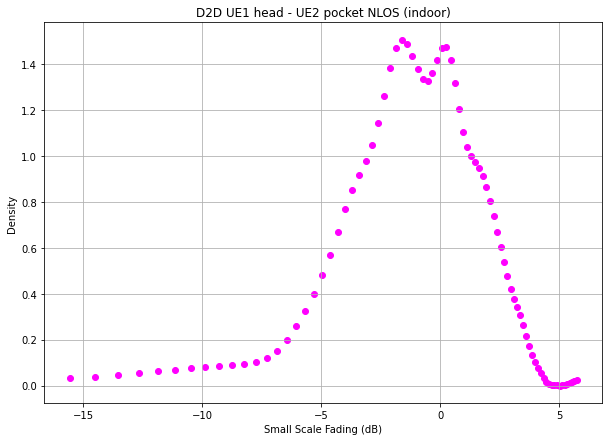

In [ ]:
case = 'D2D UE1 head - UE2 pocket NLOS (indoor)'
estParameters_eu_ku_case2 = pd.DataFrame()
# estParameters_sku_case2 = pd.DataFrame()
Xdata, Ydata = getDensityEstimationSamples(UE1head_UE2pocket_NLOS.dropna(), nExtractedSamples, case)

In [ ]:
print('='*30+' KAPPA-MU '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
ku_kappa_mse, ku_mu_mse, ku_omega_mse = geneticAlgorithm_ku(Xdata, Ydata, 221) 

fitnessType = 'RAD'
printSummary(case, fitnessType)
ku_kappa_rad, ku_mu_rad, ku_omega_rad = geneticAlgorithm_ku(Xdata, Ydata, 114.2)

print('='*30+' ETA-MU '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
eu_kappa_mse, eu_mu_mse, eu_omega_mse = geneticAlgorithm_eu(Xdata, Ydata, 337) 

fitnessType = 'RAD'
printSummary(case, fitnessType)
eu_kappa_rad, eu_mu_rad, eu_omega_rad = geneticAlgorithm_eu(Xdata, Ydata, 69.8) 


============================== KAPPA-MU ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 head - UE2 pocket NLOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 0.758782148361206 seconds.

Best Fitness: 221.62102282877575
Best Gen: 2
Kappa: 5.2989773091416525
Mu: 1.0270506604257716
Omega: 0.983673983940295
Genetic Algorithm Fitting
Fitness Type: RAD
Case: D2D UE1 head - UE2 pocket NLOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 2.4185404777526855 seconds.

Best Fitness: 114.21154808848429
Best Gen: 8
Kappa: 13.707179859803505
Mu: 0.48985060832013283
Omega: 0.9928942818342914
============================== ETA-MU ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 head - UE2 pocket NLOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 1.9678199291229248 seconds.

Best Fitness: [337.21736257]
Best Gen: 8
Kappa: 0.913687735206404
Mu: 1.6922708288093784
Omega: 1.0160620934561544
Ge

#### Estimated Parameters

In [ ]:
nls_ku_case2 = [3.0556, 1.5, 0.98751] # KappaMu NLS
# nls_eu_case2 = [3.6888, 0.93352, 1.0856] # EtaMu NLS

estParameters_eu_ku_case2['NLS - KappaMu'] = nls_ku_case2
# estParameters_eu_ku_case2['NLS - EtaMu'] = nls_eu_case2
estParameters_eu_ku_case2['GA: KappaMu - MSE'] = ku_kappa_mse, ku_mu_mse, ku_omega_mse
estParameters_eu_ku_case2['GA: KappaMu - RAD'] = ku_kappa_rad, ku_mu_rad, ku_omega_rad
estParameters_eu_ku_case2['GA: EtaMu - MSE'] = eu_eta_mse, eu_mu_mse, eu_omega_mse
estParameters_eu_ku_case2['GA: EtaMu - RAD'] = eu_eta_rad, eu_mu_rad, eu_omega_rad

index = pd.Index(['kappa/eta', 'mu', 'omega'])
estParameters_eu_ku_case2 = estParameters_eu_ku_case2.set_index(index)
display(estParameters_eu_ku_case2)


,NLS - KappaMu,GA: KappaMu - MSE,GA: KappaMu - RAD,GA: EtaMu - MSE,GA: EtaMu - RAD
kappa/eta,3.05560,5.298977,13.707180,0.970848,0.985220
mu,1.50000,1.027051,0.489851,1.692271,1.740136
omega,0.98751,0.983674,0.992894,1.016062,0.989078


#### Plots

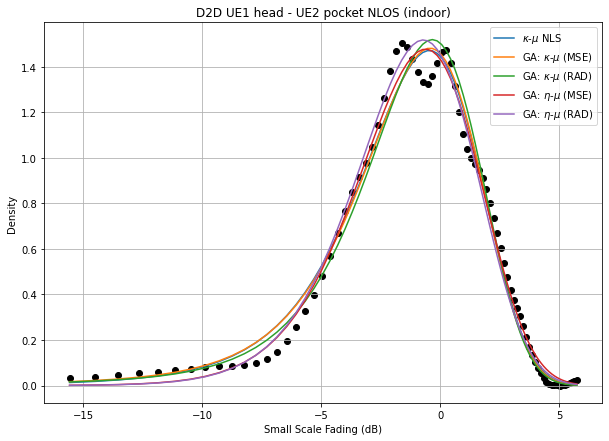

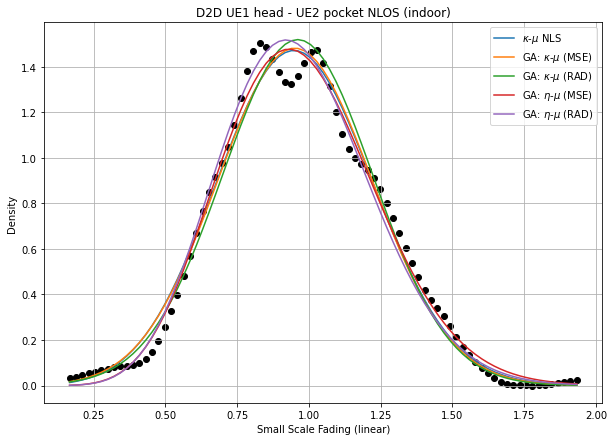

In [ ]:
ku_case2_pdf = KappaMuPDF(Xdata, nls_ku_case2[0], nls_ku_case2[1], nls_ku_case2[2]).astype(float)

plotResults(Xdata,\
     Ydata,\
     ku_case2_pdf,\
     estParameters_eu_ku_case2['GA: KappaMu - MSE'],\
     estParameters_eu_ku_case2['GA: KappaMu - RAD'],\
     estParameters_eu_ku_case2['GA: EtaMu - MSE'],\
     estParameters_eu_ku_case2['GA: EtaMu - RAD'],\
     case)

#### AIC Values

In [ ]:
## AIC Analysis
data = UE1head_UE2pocket_NLOS.dropna()
n = len(data)
K = 3

print('Case: {}'.format(case))

AIC_case2 = computeAIC(data, n, K,\
                        nls_ku_case2,\
                        estParameters_eu_ku_case2['GA: KappaMu - MSE'],\
                        estParameters_eu_ku_case2['GA: KappaMu - RAD'],\
                        estParameters_eu_ku_case2['GA: EtaMu - MSE'],\
                        estParameters_eu_ku_case2['GA: EtaMu - RAD'],\
                        )

Case: D2D UE1 head - UE2 pocket NLOS (indoor)


,Methods,Akaike Information Criteria
0,GA - KappaMu (Fitness = RAD),67.615239
1,GA - KappaMu (Fitness = MSE),67.920116
2,NLS - KappaMu,67.997133
3,GA - EtaMu (Fitness = MSE),73.757119
4,GA - EtaMu (Fitness = RAD),73.794842


### D2D UE1 texting - UE2 head LOS (indoor) [Case 3]

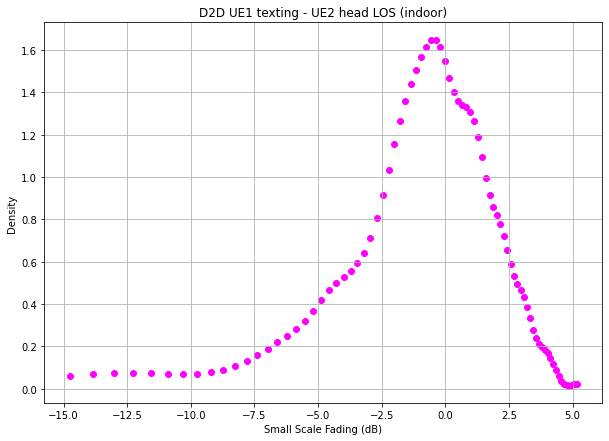

In [ ]:
case = 'D2D UE1 texting - UE2 head LOS (indoor)'
estParameters_eu_ku_case3 = pd.DataFrame()
# estParameters_sku_case3 = pd.DataFrame()
Xdata, Ydata = getDensityEstimationSamples(UE1text_UE2head_LOS.dropna(), nExtractedSamples, case)

In [ ]:
print('='*30+' KAPPA-MU '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
ku_kappa_mse, ku_mu_mse, ku_omega_mse = geneticAlgorithm_ku(Xdata, Ydata, 223) 

fitnessType = 'RAD'
printSummary(case, fitnessType)
ku_kappa_rad, ku_mu_rad, ku_omega_rad = geneticAlgorithm_ku(Xdata, Ydata, 193) 

print('='*30+' ETA-MU '+'='*30)
fitnessType = 'MSE'
printSummary(case, fitnessType)
eu_kappa_mse, eu_mu_mse, eu_omega_mse = geneticAlgorithm_eu(Xdata, Ydata, 221.8)

fitnessType = 'RAD'
printSummary(case, fitnessType)
eu_kappa_rad, eu_mu_rad, eu_omega_rad = geneticAlgorithm_eu(Xdata, Ydata, 73.9)


============================== KAPPA-MU ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 texting - UE2 head LOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 2.2877657413482666 seconds.

Best Fitness: 223.43346957917726
Best Gen: 9
Kappa: 9.569778476427054
Mu: 0.7184044852046381
Omega: 1.044764385644186
Genetic Algorithm Fitting
Fitness Type: RAD
Case: D2D UE1 texting - UE2 head LOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 11.85051703453064 seconds.

Best Fitness: 193.02832767226144
Best Gen: 8
Kappa: 29.78071800417679
Mu: 0.23971652656580017
Omega: 1.05570336054308
============================== ETA-MU ==============================
Genetic Algorithm Fitting
Fitness Type: MSE
Case: D2D UE1 texting - UE2 head LOS (indoor)

Satisfactory Threshold reached!
Elapsed time is 3.5162837505340576 seconds.

Best Fitness: [221.87594963]
Best Gen: 15
Kappa: 0.9057660576682915
Mu: 1.9833509316869995
Omega: 1.081294392177088
Genet

#### Estimated Parameters

In [ ]:
nls_ku_case3 = [3.8111, 1.5, 1.0491] # KappaMu NLS
# nls_eu_case3 = [3.6888, 0.93352, 1.0856] # EtaMu NLS

estParameters_eu_ku_case3['NLS - KappaMu'] = nls_ku_case3
# estParameters_eu_ku_case3['NLS - EtaMu'] = nls_eu_case3
estParameters_eu_ku_case3['GA: KappaMu - MSE'] = ku_kappa_mse, ku_mu_mse, ku_omega_mse
estParameters_eu_ku_case3['GA: KappaMu - RAD'] = ku_kappa_rad, ku_mu_rad, ku_omega_rad
estParameters_eu_ku_case3['GA: EtaMu - MSE'] = eu_eta_mse, eu_mu_mse, eu_omega_mse
estParameters_eu_ku_case3['GA: EtaMu - RAD'] = eu_eta_rad, eu_mu_rad, eu_omega_rad

index = pd.Index(['kappa/eta', 'mu', 'omega'])
estParameters_eu_ku_case3 = estParameters_eu_ku_case3.set_index(index)
display(estParameters_eu_ku_case3)


,NLS - KappaMu,GA: KappaMu - MSE,GA: KappaMu - RAD,GA: EtaMu - MSE,GA: EtaMu - RAD
kappa/eta,3.8111,9.569778,29.780718,0.970848,0.985220
mu,1.5000,0.718404,0.239717,1.983351,1.744755
omega,1.0491,1.044764,1.055703,1.081294,1.065057


#### Plots

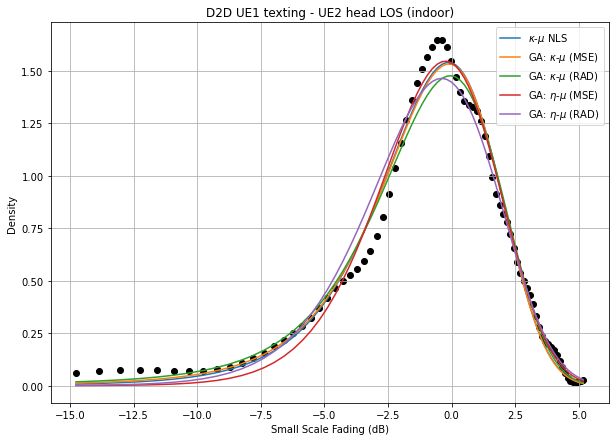

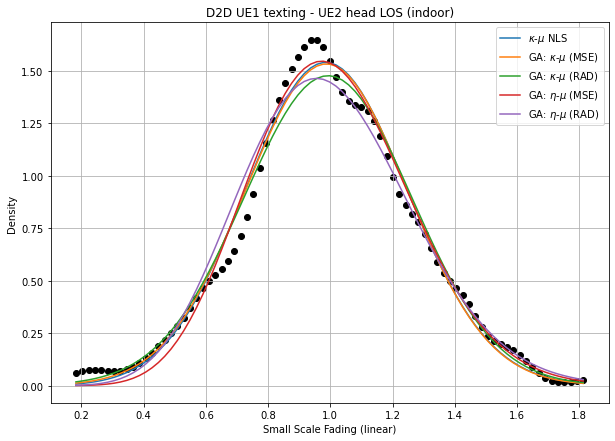

In [ ]:
ku_case3_pdf = KappaMuPDF(Xdata, nls_ku_case3[0], nls_ku_case3[1], nls_ku_case3[2]).astype(float)

plotResults(Xdata,\
     Ydata,\
     ku_case3_pdf,\
     estParameters_eu_ku_case3['GA: KappaMu - MSE'],\
     estParameters_eu_ku_case3['GA: KappaMu - RAD'],\
     estParameters_eu_ku_case3['GA: EtaMu - MSE'],\
     estParameters_eu_ku_case3['GA: EtaMu - RAD'],\
     case)

#### AIC Values

In [ ]:
## AIC Analysis
data = UE1text_UE2head_LOS.dropna()
n = len(data)
K = 3

print('Case: {}'.format(case))

AIC_case3 = computeAIC(data, n, K,\
                        nls_ku_case3,\
                        estParameters_eu_ku_case3['GA: KappaMu - MSE'],\
                        estParameters_eu_ku_case3['GA: KappaMu - RAD'],\
                        estParameters_eu_ku_case3['GA: EtaMu - MSE'],\
                        estParameters_eu_ku_case3['GA: EtaMu - RAD'],\
                        )

Case: D2D UE1 texting - UE2 head LOS (indoor)


,Methods,Akaike Information Criteria
0,GA - KappaMu (Fitness = RAD),74.831533
1,GA - KappaMu (Fitness = MSE),75.782780
2,NLS - KappaMu,77.525196
3,GA - EtaMu (Fitness = RAD),89.489151
4,GA - EtaMu (Fitness = MSE),96.321534
